# Imports

In [254]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))

import importlib
import graphs as g
import utils as u
import processing as p
import model as m
import selection as s

# Data

In [205]:
train_data = pd.read_json('input/train.json')
train_data.sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [206]:
test_data = pd.read_json('input/test.json')
test_data.sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


# Feature extraction

In [207]:
import re

def feature(text):
    if '*' in text:
        return ''
    else:
        text = list(filter(lambda t: len(t) < 11, text))
        return ','.join(text).lower()

train_data['features'] = train_data.features.map(lambda f: ','.join(f))
test_data['features'] = test_data.features.map(lambda f: ','.join(f))

In [317]:
importlib.reload(p)

managers = train_data.manager_id.append(test_data.manager_id).values
manager_le = p.label_encoder(managers, 'managers')

buildings = train_data.building_id.append(test_data.building_id).values
building_le = p.label_encoder(buildings, 'buildings')

addresses = train_data.display_address.append(test_data.display_address).values
address_le = p.label_encoder(addresses, 'addresses')

stop_words = ['fee', 'pre', 'post','exclusive', 'ok', 'sq', 'allowed', 'new']
features = train_data.features.append(test_data.features).values
features_we = p.word_encoder(features, title='features', stop_words=stop_words, max_features=100)

stop_words = ['br', 'li', 'text']
desc = train_data.description.append(test_data.description).values
desc_we = p.word_encoder(desc, title='description', stop_words=stop_words, max_features=100)

managers: 4399 
buildings: 11635 
addresses: 16068 
features: ['access', 'actual', 'appliances', 'approval', 'apt', 'areas', 'available', 'backyard', 'balcony', 'bath', 'bike', 'brick', 'building', 'cats', 'ceiling', 'ceilings', 'center', 'central', 'childrens', 'closet', 'common', 'concierge', 'construction', 'deck', 'dining', 'dishwasher', 'dogs', 'doorman', 'dryer', 'duplex', 'eat', 'elevator', 'exposed', 'fireplace', 'fitness', 'floor', 'floors', 'furnished', 'garage', 'garden', 'granite', 'green', 'gym', 'hardwood', 'high', 'highrise', 'home', 'internet', 'kitchen', 'laundry', 'level', 'light', 'live', 'loft', 'lounge', 'lowrise', 'luxury', 'marble', 'multi', 'newly', 'outdoor', 'parking', 'patio', 'pets', 'photos', 'playroom', 'pool', 'prewar', 'private', 'publicoutdoor', 'reduced', 'renovated', 'residents', 'roof', 'roofdeck', 'room', 'service', 'short', 'simplex', 'site', 'space', 'speed', 'stainless', 'steel', 'storage', 'subway', 'super', 'superintendent', 'swimming', 'term',

In [211]:
from datetime import datetime

# train
# train_data['created'] = train_data['created'].map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S').month)
train_data['manager_id'] = manager_le.transform(train_data.manager_id)
train_data['building_id'] = building_le.transform(train_data.building_id)
train_data['display_address'] = address_le.transform(train_data.display_address)
train_data['interest_level'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace=True)

# test
test_data['manager_id'] = manager_le.transform(test_data.manager_id)
test_data['building_id'] = building_le.transform(test_data.building_id)
test_data['display_address'] = address_le.transform(test_data.display_address)


In [212]:
test_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,5535,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,13274,"Elevator,Laundry in Building,Laundry in Unit,D...",40.7185,7142618,-73.9865,3076,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,13391,"Pre-War,Dogs Allowed,Cats Allowed",40.7278,7210040,-74.0000,3593,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,2813,2016-06-03 04:29:40,New York chic has reached a new level ...,990,"Doorman,Elevator,No Fee",40.7306,7103890,-73.9890,2677,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,5477,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,481,"Roof Deck,Balcony,Elevator,Laundry in Building...",40.7109,7143442,-73.9571,201,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,4428,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...",12317,"Common Outdoor Space,Cats Allowed,Dogs Allowed...",40.7650,6860601,-73.9845,3157,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [166]:
features = train_data.features.str.get_dummies(',')
# features.columns[100:400]
# train_data.features[100:200]
features.shape

(49352, 210)

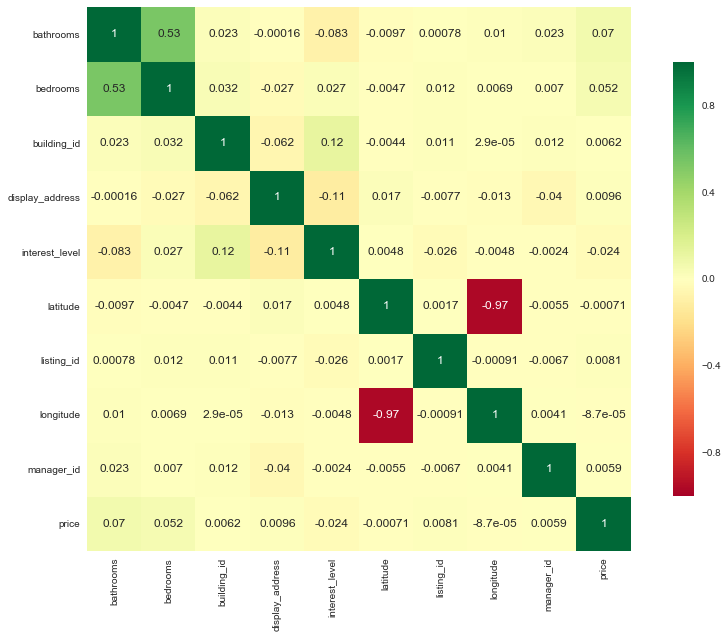

In [8]:
g.plot_correlation_map(train_data)

# Feature selection

In [269]:
labels_columns = ['interest_level']
y = train_data[labels_columns]
u.log('y', y.shape)

y: (49352, 1) 


In [379]:
features_columns = ['building_id', 'display_address', 'listing_id', 'manager_id', 'price']
features_count = len(features_columns)

x1 = train_data[features_columns]
u.log('x1', x1.shape)

x1: (49352, 5) 


In [380]:
importlib.reload(s)

fa = features_we.transform(train_data.features.values).toarray()
xf = pd.DataFrame(fa, columns=features_names, index=train_data.index)

x2 = s.kbest_filter(xf, y, features_we.get_feature_names(), k=50)

# g.plot_univariate_scores(x2, y, x2.columns)

KBest: ['actual', 'appliances', 'apt', 'balcony', 'bath', 'building', 'cats', 'ceilings', 'center', 'closet', 'deck', 'dining', 'dishwasher', 'dogs', 'doorman', 'fitness', 'floors', 'furnished', 'garage', 'granite', 'hardwood', 'high', 'internet', 'kitchen', 'laundry', 'light', 'lowrise', 'marble', 'newly', 'outdoor', 'photos', 'prewar', 'private', 'publicoutdoor', 'reduced', 'renovated', 'residents', 'roof', 'short', 'simplex', 'space', 'speed', 'stainless', 'steel', 'subway', 'term', 'terrace', 'unit', 'walk', 'war'] 
X: (49352, 50) 


In [334]:
importlib.reload(s)

desc_features = desc_we.get_feature_names()

da = desc_we.transform(train_data.description.values).toarray()
xd = pd.DataFrame(da, columns=desc_features, index=train_data.index)

x3 = s.kbest_filter(xd, y, desc_features, k=10)

# g.plot_univariate_scores(x3, y, x3.columns)

KBest: ['amazing', 'fee', 'free', 'information', 'kagglemanager', 'large', 'location', 'renovated', 'renthop', 'space'] 
X: (49352, 10) 


In [374]:
importlib.reload(p)

xc1 = pd.DataFrame(p.scale(x1)[0], index=x1.index)
x = pd.merge(xc1, x2, left_index=True, right_index=True)
x = pd.merge(x, x3, left_index=True, right_index=True)

# X2 = x2.as_matrix()
# X3 = x3.as_matrix()
# X = np.concatenate((X1, X2, X3), axis=1)

X = x.as_matrix()
Y = p.onehot(y)

print(X[0])
print(Y[0])

X: (49352, 5) 
Y: (49352, 3) 
[-0.31105435  0.35386594  1.4821605  -0.53413236 -0.03762122  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.        ]
[ 0.  1.  0.]


# Model

Train on 34546 samples, validate on 14806 samples
Epoch 1/30
34546/34546 [==============================] - 4s - loss: 1.9261 - acc: 0.1792 - val_loss: 1.9259 - val_acc: 0.1825

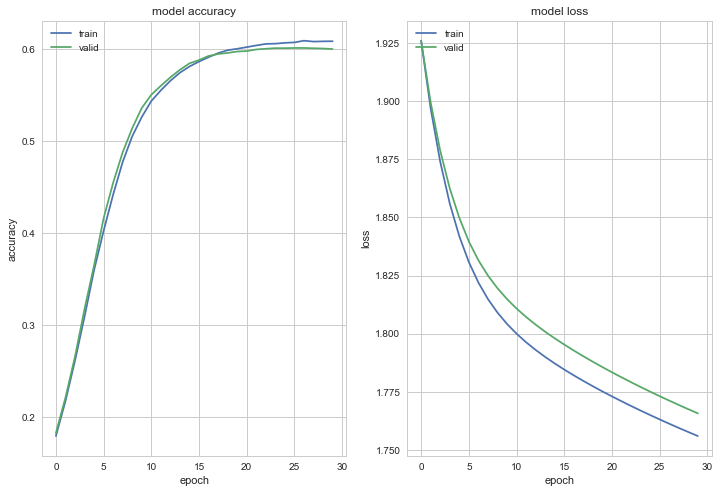

In [375]:
importlib.reload(m)
importlib.reload(g)
from keras import optimizers
from keras import callbacks

class_weights = u.get_class_weights(y.interest_level, smooth_factor=0.1)
tb = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
callbacks = []

model = m.keras_classification(X.shape[1], Y.shape[1])
optimizer = optimizers.Adam(lr=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.3, epochs=30, class_weight=class_weights, callbacks=callbacks)
model.save('rental.h5')

plt.figure(figsize=(12,8))
g.plot_accuracy(history)
g.plot_loss(history)

# Prediction


In [243]:
xxc = test_data[features_columns]
print(xxc.shape)

xfa = features_we.transform(test_data.features.values).toarray()
xxf = pd.DataFrame(xfa, columns=features_names, index=test_data.index)
print(xxf.shape)

xx = pd.merge(xxc, xxf, left_index=True, right_index=True)
print(xx.shape)

XX = scaler.transform(xx)
print(XX.shape)

(74659, 5)
(74659, 20)
(74659, 25)
(74659, 25)


In [244]:
YY = model.predict(XX)
print(YY.shape)
print(YY[:10])

(74659, 3)
[[ 0.31261647  0.37511638  0.31226721]
 [ 0.71323466  0.17497879  0.11178662]
 [ 0.53717238  0.19526769  0.26755989]
 [ 0.26491058  0.45452172  0.28056774]
 [ 0.28420055  0.40922543  0.30657402]
 [ 0.38816887  0.38215137  0.22967976]
 [ 0.31628162  0.39394382  0.28977454]
 [ 0.29942057  0.32414582  0.37643358]
 [ 0.62552339  0.23341587  0.14106072]
 [ 0.31701413  0.43529797  0.24768785]]


# Submission

In [245]:
import time
sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['listing_id', 'high', 'medium', 'low'])
submission.listing_id = sample.listing_id
submission.low = YY[:,0]
submission.medium = YY[:,1]
submission.high = YY[:,2]
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(74659, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Data columns (total 4 columns):
listing_id    74659 non-null int64
high          74659 non-null float32
medium        74659 non-null float32
low           74659 non-null float32
dtypes: float32(3), int64(1)
memory usage: 1.4 MB


# References

* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id/
* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/some-insights-on-building-id
* https://www.kaggle.com/guoday/two-sigma-connect-rental-listing-inquiries/cv-statistics-better-parameters-and-explaination/notebook